In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch
import torchvision
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# baja y lee los datos
training = torchvision.datasets.FashionMNIST(root="./", train=True, download=True)
train_loader = torch.utils.data.DataLoader(training,shuffle=True)

testing = torchvision.datasets.FashionMNIST(root="./", train=False, download=True, 
                                            transform=torchvision.transforms.Normalize((0), (1.0)))
testing_loader = torch.utils.data.DataLoader(testing, shuffle=True)

torch.Size([60000, 28, 28])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


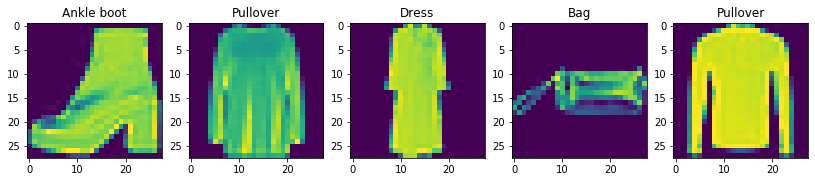

In [4]:
# muestra algunos ejemplos
print(train_loader.dataset.data.size())
print(train_loader.dataset.classes)
n_items = train_loader.dataset.data.size()[0]
random_items = np.random.choice(np.arange(n_items), 5)

plt.figure(figsize=(14,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    item  = random_items[i]
    plt.imshow(train_loader.dataset.data[item])
    plt.title(train_loader.dataset.classes[train_loader.dataset.targets[item]] )

In [6]:
# Selecciona y normaliza 600 para entrenar
train  = train_loader.dataset.data[:600].float()
target = train_loader.dataset.targets[:600].float()

mean = train.mean(dim=0)
std = train.std(dim=0)
std[std==0]=1.0

for i in range(len(train)):
    train[i] = (train[i]-mean)/std
np.shape(train)

torch.Size([600, 28, 28])

In [7]:
print(target[0:15])

tensor([9., 0., 0., 3., 0., 2., 7., 2., 5., 5., 0., 9., 5., 5., 7.])


In [14]:
X_train = train.unsqueeze(1)
# n = torch.nn.Conv2d(1, 4, 4, stride=1) # in-channels = 1, out-channels = 4, kernel=4
# new_tensor = n(X_train)
# print(new_tensor.size())

In [9]:
# # muestra los resultados de las cuatro capas de convolucion
# plt.figure(figsize=(14,14))
# for i in range(5):
#     plt.subplot(5,5,i+1)
#     plt.imshow(X_train[i][0].detach().numpy())
#     plt.title(train_loader.dataset.classes[train_loader.dataset.targets[i]] )
    
#     for j in range(4):
#         plt.subplot(5,5,(i+1)+5*(j+1))
#         plt.imshow(new_tensor[i][j].detach().numpy())


In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 4,4, stride=1)
        self.conv2 = nn.Conv2d(4, 16, 4)
         # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 10)  # 6*6 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=10, bias=True)
)


In [15]:
print(X_train.size())
print(target.size())

torch.Size([600, 1, 28, 28])
torch.Size([600])


In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2) #lr: learning rate
# train

epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)

for epoch in range(epochs):

    optimizer.zero_grad()
    out = net(X_train)
    #print(out.size(),target.size())
    loss = criterion(out, target.long())
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(target, Y_predicted, average='macro')

/home/john/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0, 0.5, 'loss')

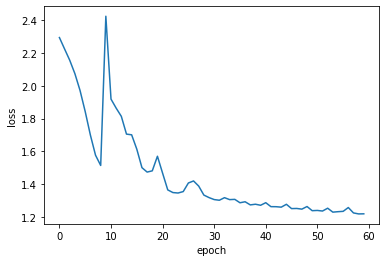

In [17]:
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')

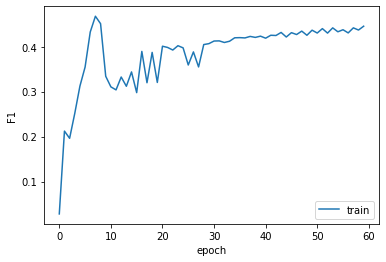

In [18]:
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()